# Resamplingに関するデータ観察

In [109]:
from datetime import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from util.preprocess.csi import linear_interpolate_resampling
from util.preprocess.handle_session_data import convert_jst_to_utc, load_meta_data, get_session_data

In [58]:
def filter_by_mac(df, target_mac_addr):
    return df[(df['mac_addr'] == target_mac_addr)]

def filter_by_sig_mode(df, target_sig_mode):
    return df[(df['sig_mode'] == target_sig_mode)]

In [86]:
def validation_csi_data(df):
    # 'csi_data' の処理
    df.loc[:, 'csi_data'] = df['csi_data'].str.strip('[]').str.split()
    df.loc[:, 'csi_data'] = df['csi_data'].apply(lambda x: [int(i) for i in x] if len(x) == 128 else None)
    df = df.dropna(subset=['csi_data'])

    return df[['csi_data', 'timestamp']]

In [37]:
def calc_subcarrier_data(row):
    data = (
        [row['timestamp']] +
        # real parts
        [row['csi_data'][2 * i] for i in range(64)] +  
        # imag parts
        [row['csi_data'][2 * i + 1] for i in range(64)] +  
        # amplitude
        [np.sqrt(row['csi_data'][2 * i]**2 + row['csi_data'][2 * i + 1]**2) for i in range(64)] + 
        # phase
        [np.arctan2(row['csi_data'][2 * i + 1], row['csi_data'][2 * i]) for i in range(64)] 
    )

    return data

In [125]:
def process(df):

    # MACアドレスと802.11nでフィルタリング
    df = filter_by_mac(df, '08:D1:F9:34:A5:98')
    df = filter_by_sig_mode(df, 1)

    df = validation_csi_data(df)
    
    # MultiIndex の列名を作成
    columns = [
        ('timestamp', ''), 
        *[(f'real', f'sc_{i}') for i in range(64)], 
        *[(f'imag', f'sc_{i}') for i in range(64)], 
        *[(f'amp', f'sc_{i}') for i in range(64)], 
        *[(f'phase', f'sc_{i}') for i in range(64)]
    ]
    
    # 各サブキャリアの値を計算して DataFrame に追加
    data = [calc_subcarrier_data(row) for _, row in df.iterrows()]
    
    # MultiIndex を持つ DataFrame を作成
    df = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(columns))

    return df

In [56]:
def get_session(session_df, i):
    row = session_df.iloc[i]
    session_id = row['session_id']
    location = row['location']
    start_time_jst_str = row['start_time_JST']
    end_time_jst_str = row['end_time_JST']

    start_time_jst = datetime.strptime(start_time_jst_str, '%Y-%m-%d %H:%M:%S')
    end_time_jst = datetime.strptime(end_time_jst_str, '%Y-%m-%d %H:%M:%S')
    print(f"Session ID: {session_id}, Location: {location}, Start Time: {start_time_jst}, End Time: {end_time_jst}")

    return session_id, location, start_time_jst, end_time_jst

In [52]:
def get_csi_data_df(session_id, location):
    session_dirpath = raw_data_dirpath / location / session_id 
    csi_data_filepath = session_dirpath / f'csi_{session_id}.csv'
    df = pd.read_csv(csi_data_filepath)
    df['timestamp'] = pd.to_datetime(pd.to_numeric(df['timestamp'], errors='coerce'), unit='s')
    df['sig_mode'] = pd.to_numeric(df['sig_mode'], errors='coerce')

    return df

In [14]:
root_data_dirpath = Path('/tf/nas/data')
raw_data_dirpath = root_data_dirpath / 'raw'

In [15]:
session_data_filepath = raw_data_dirpath / 'session.csv'
session_df = pd.read_csv(session_data_filepath)

In [16]:
session_df

,session_id,location,start_time_JST,end_time_JST
0,session_20240926_151603,512,2024-09-26 15:17:00,2024-09-26 15:22:00
1,session_20240926_152330,512,2024-09-26 15:24:00,2024-09-26 15:29:00
2,session_20240926_153446,512,2024-09-26 15:35:00,2024-09-26 15:40:00
3,session_20240926_154624,512,2024-09-26 15:47:00,2024-09-26 15:52:00
4,session_20240926_165118,511,2024-09-26 16:52:00,2024-09-26 16:57:00
5,session_20240926_170021,511,2024-09-26 17:01:00,2024-09-26 17:06:00
6,session_20240926_171232,511,2024-09-26 17:13:00,2024-09-26 17:18:00
7,session_20240926_172237,511,2024-09-26 17:23:00,2024-09-26 17:28:00
8,session_20240926_175737,514B,2024-09-26 17:58:00,2024-09-26 18:03:00
9,session_20240926_180441,514B,2024-09-26 18:05:00,2024-09-26 18:10:00


In [148]:
len(session_df)

12

In [151]:
session_id, location, start_time_jst, end_time_jst = get_session(session_df, 2)

Session ID: session_20240926_153446, Location: 512, Start Time: 2024-09-26 15:35:00, End Time: 2024-09-26 15:40:00


In [152]:
csi_data_df = get_csi_data_df(session_id, location)

In [153]:
df = process(csi_data_df)

In [154]:
real = df['real'].values
imag = df['imag'].values
amp = df['amp'].values
phase = df['phase'].values
timestamp = df['timestamp'].apply(lambda x: x.timestamp()).tolist()

<AxesSubplot: >

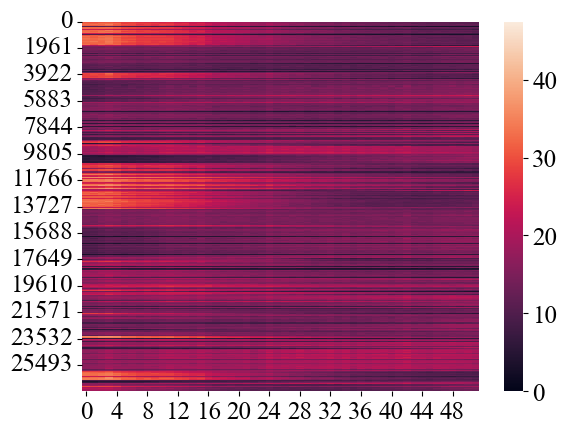

In [191]:
trash_subcarriers = [0,1,2,3,4,5,32,59,60,61,62,63]
useful_subcarriers = [k for k in range(64) if k not in trash_subcarriers]

sns.heatmap(amp[:, useful_subcarriers])

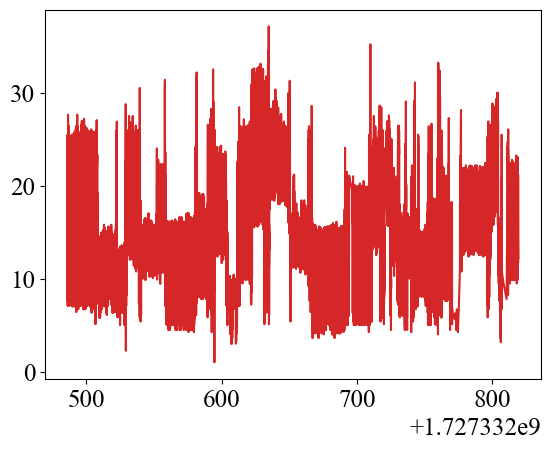

In [192]:
plt.plot(timestamp, amp[:, 20])

In [193]:
target_fps = 100
real_resampled = linear_interpolate_resampling(real, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)
imag_resampled = linear_interpolate_resampling(imag, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)
amp_resampled = linear_interpolate_resampling(amp, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)
phase_resampled = linear_interpolate_resampling(phase, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)

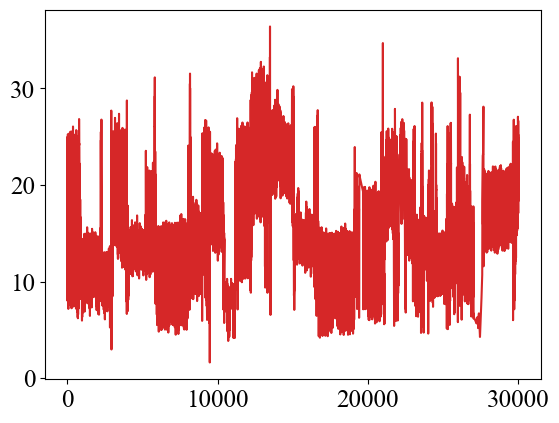

In [194]:
plt.plot(amp_resampled[:, 20])

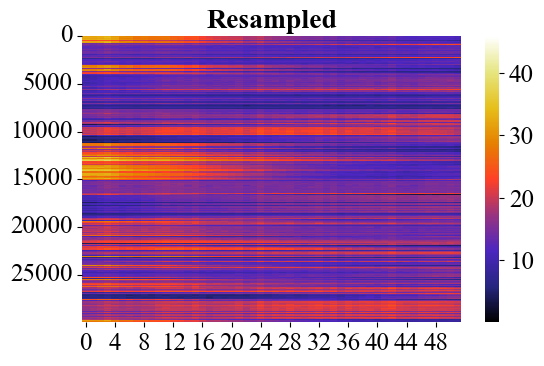

In [201]:
plot_csi(amp_resampled[:, useful_subcarriers], 'Resampled')

In [170]:
from util.plot.heatmap import plot_csi
from util.preprocess.csi.denoising import hampel_filter
from util.preprocess.csi.normalize import normalize_csi_amplitudes_by_frame_power
from util.preprocess.csi.phase import remove_timing_offset

In [197]:
amp_filtered = hampel_filter(amp_resampled[:, useful_subcarriers], window_size=200, n_sigmas=3)

Output()

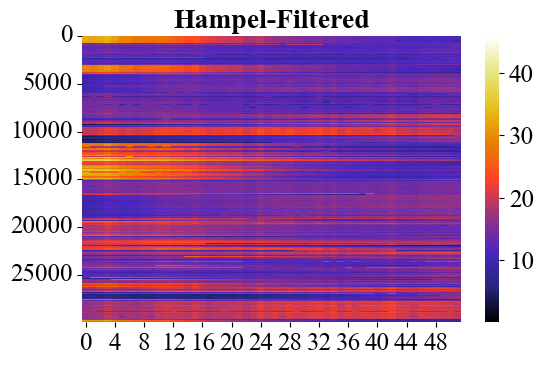

In [198]:
plot_csi(amp_filtered, 'Hampel-Filtered')

In [199]:
amp_normalized = normalize_csi_amplitudes_by_frame_power(amp_filtered)

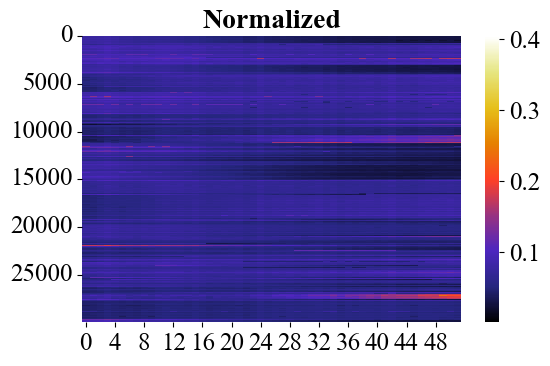

In [200]:
plot_csi(amp_normalized, 'Normalized')